#### Proyecto Programación Avanzada: 
# Práctica 1, EDA eucaliptos en Cantabria

En esta práctica vamos a realizar un análisis exploratorio de datos para el género de eucaliptos, debido a que son una especie invasora en la península.

Primero, solucionamos el problema con la librería PROJ y GDAL

In [1]:
import os
import getpass

usuario = getpass.getuser()

# os.environ['GDAL_DATA'] = f'/opt/anaconda3/envs/geoenv/share/gdal'
# os.environ['PROJ_LIB'] = f'/opt/anaconda3/envs/geoenv/share'

# en windows
os.environ['GDAL_DATA'] = f'C:\\Users\\{usuario}\\anaconda3\\envs\\advprog\\Library\\share\\gdal'
os.environ['PROJ_LIB'] = f'C:\\Users\\{usuario}\\anaconda3\\envs\\advprog\\Library\\share\\proj'

segundo, importamos los datos necesarios, en principio vamos a empezar con datos puntuales de toda España.

In [2]:
import sys

sys.argv[1] = "C:\\Users\\angel\\Documents\\Programacion_avanzada\\practicas\\Geodatos\\" #Ángel

euc_points = sys.argv[1] + "eucaliptos_españa_puntos\\eucalyptus_points.csv"


### 1.- Tratamiento de datos no espaciales

Ahora, vamos a empezar a tratar los datos, primero, hemos descargado de GBIF datos puntuales para toda España, vamos a tratarlos y luego los convertiremos en un geodato gracias a los datos de latitud y longitud.

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray
import shapely

eucpoints_tabla = pd.read_table(euc_points)

C:\Users\angel\AppData\Local\Temp\ipykernel_3688\1555947320.py:7: DtypeWarning: Columns (10,14,16,17,29,39,40,41,43,44,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  eucpoints_tabla = pd.read_table(euc_points)


Esto nos indica que la tabla tiene "mixed types", por lo cual, da problemas. Vamos a solucionarlo

In [4]:
eucpoints_tabla = pd.read_table(euc_points, low_memory=False)
print(eucpoints_tabla.dtypes)

gbifID                                int64
datasetKey                           object
occurrenceID                         object
kingdom                              object
phylum                               object
class                                object
order                                object
family                               object
genus                                object
species                              object
infraspecificEpithet                 object
taxonRank                            object
scientificName                       object
verbatimScientificName               object
verbatimScientificNameAuthorship     object
countryCode                          object
locality                             object
stateProvince                        object
occurrenceStatus                     object
individualCount                     float64
publishingOrgKey                     object
decimalLatitude                     float64
decimalLongitude                

Aquellas con el tipo "object" son las que representan tipos mixtos que dan problema, vamos a ver cuáles nos hacen falta y cuales podemos eliminar

In [10]:
eucpoints_tabla = eucpoints_tabla.drop(columns=["datasetKey", "occurrenceID", "infraspecificEpithet",
                                             "taxonRank", "scientificName", "verbatimScientificName", 
                                             "verbatimScientificNameAuthorship", "publishingOrgKey", 
                                             "eventDate", "basisOfRecord", "institutionCode", "collectionCode", 
                                             "catalogNumber", "recordNumber", "identifiedBy", "dateIdentified", 
                                             "license", "rightsHolder", "recordedBy", "establishmentMeans", 
                                             "mediaType", "issue", "locality", "typeStatus", "stateProvince", 
                                                "occurrenceStatus", "gbifID", "kingdom", "phylum", "class", "order", 
                                               "countryCode", "individualCount", "family", "elevationAccuracy", "depth",
                                               "lastInterpreted", "taxonKey", "speciesKey", "coordinateUncertaintyInMeters", 
                                               "coordinatePrecision", "depthAccuracy", "day", "month", "year"], errors="ignore")
eucpoints_tabla

,genus,species,decimalLatitude,decimalLongitude,elevation
1,Eucalyptus,Eucalyptus globulus,43.516539,-5.270636,157.00
2,Eucalyptus,Eucalyptus globulus,42.567851,-8.873670,80.38
3,Eucalyptus,Eucalyptus globulus,42.928194,-8.113348,489.00
4,Eucalyptus,Eucalyptus globulus,42.889623,-8.571294,393.00
5,Eucalyptus,Eucalyptus globulus,43.714230,-7.611280,NaN
...,...,...,...,...,...
178936,Eucalyptus,Eucalyptus camaldulensis,28.110870,-16.578650,530.00
178937,Eucalyptus,Eucalyptus camaldulensis,28.117600,-16.587020,705.00
178944,Eucalyptus,Eucalyptus globulus,39.779999,2.700000,1.00
178945,Eucalyptus,Eucalyptus globulus,39.770000,2.700000,1.00


Ahora vamos a eliminar aquellas que tengan vacía algunas de las coordenadas vacías

In [11]:
eucpoints_tabla["decimalLatitude"] = eucpoints_tabla["decimalLatitude"].replace("", np.nan)
eucpoints_tabla["decimalLongitude"] = eucpoints_tabla["decimalLongitude"].replace("", np.nan)

eucpoints_tabla = eucpoints_tabla.dropna(subset=["decimalLatitude", "decimalLongitude"])

eucpoints_tabla

,genus,species,decimalLatitude,decimalLongitude,elevation
1,Eucalyptus,Eucalyptus globulus,43.516539,-5.270636,157.00
2,Eucalyptus,Eucalyptus globulus,42.567851,-8.873670,80.38
3,Eucalyptus,Eucalyptus globulus,42.928194,-8.113348,489.00
4,Eucalyptus,Eucalyptus globulus,42.889623,-8.571294,393.00
5,Eucalyptus,Eucalyptus globulus,43.714230,-7.611280,NaN
...,...,...,...,...,...
178936,Eucalyptus,Eucalyptus camaldulensis,28.110870,-16.578650,530.00
178937,Eucalyptus,Eucalyptus camaldulensis,28.117600,-16.587020,705.00
178944,Eucalyptus,Eucalyptus globulus,39.779999,2.700000,1.00
178945,Eucalyptus,Eucalyptus globulus,39.770000,2.700000,1.00


Lo siguiente, será transformarlo a geodato para poder extraer solo aquellos que se encuentran dentro del shapefile de Cantabria

In [12]:
from shapely.geometry import Point
from pyproj import CRS

eucpoints = eucpoints_tabla.copy()
eucpoints["geometry"] = eucpoints.apply(
    lambda row: Point(row["decimalLongitude"], row["decimalLatitude"]), axis=1
)
crs = CRS("EPSG:4326")
gdf = gpd.GeoDataFrame(eucpoints, geometry="geometry", crs=crs)

gdf.columns = [col[:10] for col in gdf.columns]

print(gdf.head())
gdf.set_crs("EPSG:4326", inplace=True)


        genus              species  decimalLat  decimalLon  elevation  \
1  Eucalyptus  Eucalyptus globulus   43.516539   -5.270636     157.00   
2  Eucalyptus  Eucalyptus globulus   42.567851   -8.873670      80.38   
3  Eucalyptus  Eucalyptus globulus   42.928194   -8.113348     489.00   
4  Eucalyptus  Eucalyptus globulus   42.889623   -8.571294     393.00   
5  Eucalyptus  Eucalyptus globulus   43.714230   -7.611280        NaN   

                    geometry  
1  POINT (-5.27064 43.51654)  
2  POINT (-8.87367 42.56785)  
3  POINT (-8.11335 42.92819)  
4  POINT (-8.57129 42.88962)  
5  POINT (-7.61128 43.71423)  


,genus,species,decimalLat,decimalLon,elevation,geometry
1,Eucalyptus,Eucalyptus globulus,43.516539,-5.270636,157.00,POINT (-5.27064 43.51654)
2,Eucalyptus,Eucalyptus globulus,42.567851,-8.873670,80.38,POINT (-8.87367 42.56785)
3,Eucalyptus,Eucalyptus globulus,42.928194,-8.113348,489.00,POINT (-8.11335 42.92819)
4,Eucalyptus,Eucalyptus globulus,42.889623,-8.571294,393.00,POINT (-8.57129 42.88962)
5,Eucalyptus,Eucalyptus globulus,43.714230,-7.611280,NaN,POINT (-7.61128 43.71423)
...,...,...,...,...,...,...
178936,Eucalyptus,Eucalyptus camaldulensis,28.110870,-16.578650,530.00,POINT (-16.57865 28.11087)
178937,Eucalyptus,Eucalyptus camaldulensis,28.117600,-16.587020,705.00,POINT (-16.58702 28.1176)
178944,Eucalyptus,Eucalyptus globulus,39.779999,2.700000,1.00,POINT (2.7 39.78)
178945,Eucalyptus,Eucalyptus globulus,39.770000,2.700000,1.00,POINT (2.7 39.77)


In [13]:
print(gdf.crs)  # Verificar que el sistema de coordenadas es correcto

EPSG:4326


In [14]:
gdf.to_file( sys.argv[1]+"eucpoints.shp", driver="ESRI Shapefile", encoding="utf-8", engine="fiona")

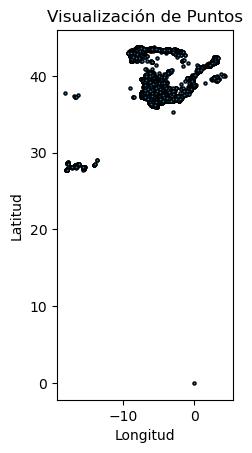

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt
import sys

# Cargar el shapefile
geodato_prueba = gpd.read_file(sys.argv[1] + "eucpoints.shp")


# Visualizar
geodato_prueba.plot(markersize=5, edgecolor="black")
plt.title("Visualización de Puntos")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()



Ahora que lo hemos pasado a un archivo shapefile, vamos a extraer por la localización de cantabria concretamente.

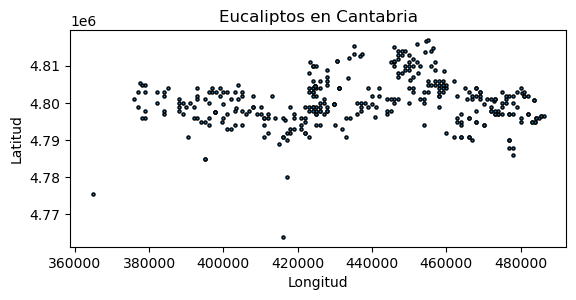

In [16]:
puntos_euc_españa = gpd.read_file(sys.argv[1] + "eucpoints.shp")
cantabria = gpd.read_file(sys.argv[1] + "cantabria_25830.shp")

# Verificar y transformar el CRS si es necesario
if cantabria.crs != "EPSG:25830":
    cantabria = cantabria.to_crs(epsg=25830)

# Convertir puntos_euc_españa a EPSG:25830
eucaliptos = puntos_euc_españa.to_crs(epsg=25830)

# Usar clip para obtener solo los puntos dentro de Cantabria
eucal_cant = gpd.clip(eucaliptos, cantabria)

# Graficar los puntos resultantes
eucal_cant.plot(markersize=5, edgecolor="black")
plt.title("Eucaliptos en Cantabria")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


y, como ha salido bien, vamos a guardar el geodato de eucaliptos de cantabria

In [17]:
eucal_cant.to_file(sys.argv[1]+"eucal_cant.shp", driver="ESRI Shapefile", encoding="utf-8", engine="fiona")

print(eucal_cant.crs)

EPSG:25830


Volvemos a cargar los datos relevantes y cargamos también los datos de eucaliptos del mapa forestal

In [27]:
eucal_cant = gpd.read_file(sys.argv[1] + "eucal_cant.shp")
euc_mfe_cant = gpd.read_file(sys.argv[1] + "Eucaliptales_Cornisa_Cantabrica\\Eucaliptales_Cornisa_Cantabrica.shp")
cantabria = gpd.read_file(sys.argv[1] + "cantabria_25830.shp")

In [19]:
eucal_cant

,genus,species,decimalLat,decimalLon,elevation,geometry
0,Eucalyptus,Eucalyptus globulus,43.118865,-4.661279,NaN,POINT (364851.922 4775354.135)
1,Eucalyptus,Eucalyptus globulus,43.208872,-4.291274,NaN,POINT (395107.05 4784819.375)
2,Eucalyptus,Eucalyptus globulus,43.208872,-4.291274,NaN,POINT (395107.05 4784819.375)
3,Eucalyptus,Eucalyptus globulus,43.262917,-4.350480,420.98,POINT (390394.463 4790897.316)
4,Eucalyptus,Eucalyptus globulus,43.290900,-4.281900,NaN,POINT (396008.177 4793917.334)
...,...,...,...,...,...,...
350,Eucalyptus,Eucalyptus globulus,43.484901,-3.539052,NaN,POINT (456409.81 4814805.63)
351,Eucalyptus,Eucalyptus globulus,43.485200,-3.667800,NaN,POINT (445998.906 4814914.295)
352,Eucalyptus,Eucalyptus globulus,43.494600,-3.593700,NaN,POINT (451998.399 4815912.846)
353,Eucalyptus,Eucalyptus globulus,43.501545,-3.561550,103.47,POINT (454602.986 4816666.108)


Debido a que parece que faltan muchos datos de elevación, vamos a hacer más hincapié en ello para ver si nos interesa borrar la columna y crear más adelante una relación espacial con el MDT

In [25]:
import pandas as pd

# Filtramos solo los registros donde no existe elevación
sin_elevacion = eucal_cant[eucal_cant["elevation"].isna()]

# Contamos los individuos por especie
conteo_especies = sin_elevacion["species"].value_counts()

# Convertimos a DataFrame para mostrarlo mejor
conteo_df = conteo_especies.reset_index()
conteo_df.columns = ["Especie", "Cantidad sin Elevación"]  # Renombrar correctamente

# Ordenamos por cantidad descendente
conteo_df = conteo_df.sort_values(by="Cantidad sin Elevación", ascending=False)

# Mostrar tabla
print(conteo_df)



                    Especie  Cantidad sin Elevación
0       Eucalyptus globulus                     326
1  Eucalyptus camaldulensis                       2
2      Eucalyptus pulchella                       2
3         Eucalyptus nitens                       1


Debido a la ausencia de tantos datos de elevación, decidimos también eliminarla de la tabla

In [74]:
eucal_cant = eucal_cant.drop(columns=["elevation"])

Ahora vamos a observar la cantidad total de eucaliptos de cada especie. Hay que aclarar que la presencia indica que al menos hay uno.

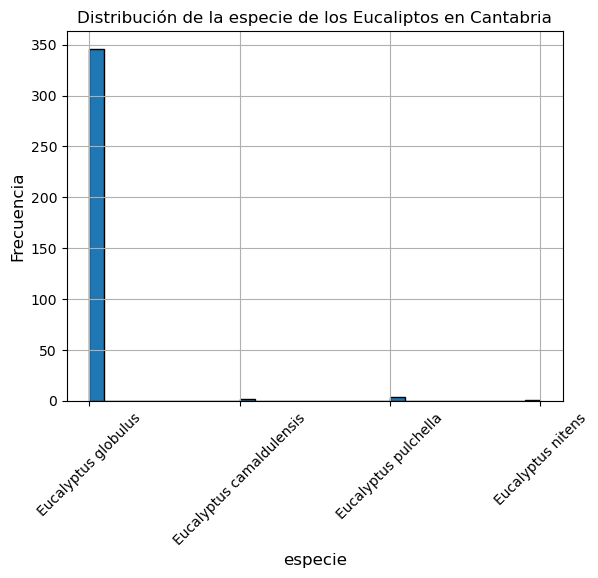

In [33]:
import matplotlib.pyplot as plt

# Crear histograma de la columna que te interesa (por ejemplo, "altura")
eucal_cant["species"].hist(bins=30, edgecolor="black")

# Personalizar el gráfico
plt.title("Distribución de la especie de los Eucaliptos en Cantabria")
plt.xlabel("especie", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.xticks(fontsize=10, rotation=45)

plt.show()


Ahora vamos a ver los datos de eucaliptos del mapa forestal de España para cantabria:

In [28]:
euc_mfe_cant

,Poligon,ORIGEN,PRO_F,ccaa_F,ESTRATOIFN,Superficie,NUT2_NOM,NUT3_NOM,TipesTR25,DesTipEstr,...,UsoIFN,n_CLAMFE,UsoMFE,n_REGBIO,RegBio,LULUCF,Shape_Area,layer,path,geometry
0,115779,MFE25,33,12,10,0.465237,Principado de Asturias,Asturias,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,4652.368141,Eucaliptales_Astures,C:\Users\jguil\Desktop\mfe\Eucaliptales_Asture...,"POLYGON ((165606.484 4816392.753, 165693.77 48..."
1,116006,MFE25,33,12,10,0.274108,Principado de Asturias,Asturias,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,2741.080943,Eucaliptales_Astures,C:\Users\jguil\Desktop\mfe\Eucaliptales_Asture...,"POLYGON ((167591.977 4816495.528, 167591.973 4..."
2,116104,MFE25,33,12,09,1.739454,Principado de Asturias,Asturias,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,17394.537537,Eucaliptales_Astures,C:\Users\jguil\Desktop\mfe\Eucaliptales_Asture...,"POLYGON ((163934.391 4816818.976, 163934.389 4..."
3,116260,MFE25,33,12,08,0.040862,Principado de Asturias,Asturias,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,408.618738,Eucaliptales_Astures,C:\Users\jguil\Desktop\mfe\Eucaliptales_Asture...,"POLYGON ((163340.878 4817101.734, 163340.873 4..."
4,116425,MFE25,33,12,08,1.480848,Principado de Asturias,Asturias,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,14808.478608,Eucaliptales_Astures,C:\Users\jguil\Desktop\mfe\Eucaliptales_Asture...,"POLYGON ((162116.806 4814938.064, 162100.631 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17911,14183892,MFE25,20,21,15,0.365187,País Vasco,Gipuzkoa,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,3651.871712,Eucaliptales_Vascos,C:\Users\jguil\Desktop\mfe\Eucaliptales_Vascos...,"POLYGON ((586819.729 4797924.92, 586818.129 47..."
17912,14191017,MFE25,20,21,16,1.775191,País Vasco,Gipuzkoa,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,17751.910807,Eucaliptales_Vascos,C:\Users\jguil\Desktop\mfe\Eucaliptales_Vascos...,"POLYGON ((587955.334 4785658.633, 587963.473 4..."
17913,14191018,MFE25,20,21,16,6.275164,País Vasco,Gipuzkoa,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,62751.643097,Eucaliptales_Vascos,C:\Users\jguil\Desktop\mfe\Eucaliptales_Vascos...,"POLYGON ((586310.753 4785562.604, 586362.014 4..."
17914,14170188,MFE25,20,21,15,2.491701,País Vasco,Gipuzkoa,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,24917.012035,Eucaliptales_Vascos,C:\Users\jguil\Desktop\mfe\Eucaliptales_Vascos...,"POLYGON ((556372.017 4788852.573, 556359.432 4..."


Como podemos observar, resulta que no son solo los de cantabria, por lo que lo que vamos a hacer es filtrar por los de la región de estudio, que coincide con la columna "NUT3_NOM"

In [33]:
euc_mfe_cant = euc_mfe_cant[euc_mfe_cant["NUT3_NOM"] == "Cantabria"]

euc_mfe_cant

,Poligon,ORIGEN,PRO_F,ccaa_F,ESTRATOIFN,Superficie,NUT2_NOM,NUT3_NOM,TipesTR25,DesTipEstr,...,UsoIFN,n_CLAMFE,UsoMFE,n_REGBIO,RegBio,LULUCF,Shape_Area,layer,path,geometry
2392,252888,MFE25,39,13,02,0.059789,Cantabria,Cantabria,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,5.978893e+02,Eucaliptales_Cantabros,C:/Users/jguil/Desktop/mfe/Eucaliptales_Cantab...,"POLYGON ((376808.859 4795531.215, 376808.167 4..."
2393,252966,MFE25,39,13,02,0.208200,Cantabria,Cantabria,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,2.082001e+03,Eucaliptales_Cantabros,C:/Users/jguil/Desktop/mfe/Eucaliptales_Cantab...,"POLYGON ((376792.163 4796557.079, 376786.877 4..."
2394,262070,MFE25,39,13,01,2.063254,Cantabria,Cantabria,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,2.063254e+04,Eucaliptales_Cantabros,C:/Users/jguil/Desktop/mfe/Eucaliptales_Cantab...,"POLYGON ((376118.302 4802814.211, 376079.183 4..."
2395,272145,MFE25,39,13,01,133.896730,Cantabria,Cantabria,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,1.338967e+06,Eucaliptales_Cantabros,C:/Users/jguil/Desktop/mfe/Eucaliptales_Cantab...,"POLYGON ((377397.421 4800004.568, 377399.782 4..."
2396,272149,MFE25,39,13,01,23.725829,Cantabria,Cantabria,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,2.372583e+05,Eucaliptales_Cantabros,C:/Users/jguil/Desktop/mfe/Eucaliptales_Cantab...,"POLYGON ((376108.881 4800574.938, 376109.561 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4107,406502,MFE25,39,13,03,1.316862,Cantabria,Cantabria,12,Bosque de Plantación,...,Monte con arbolado ralo. Bosque de plantaciones,122,Arbolado ralo,2,Atlántica,112,1.316862e+04,Eucaliptales_Cantabros,C:/Users/jguil/Desktop/mfe/Eucaliptales_Cantab...,"POLYGON ((406728.418 4797344.683, 406708.351 4..."
4108,441326,MFE25,39,13,01,262.878941,Cantabria,Cantabria,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,2.628789e+06,Eucaliptales_Cantabros,C:/Users/jguil/Desktop/mfe/Eucaliptales_Cantab...,"POLYGON ((405132.056 4804865.337, 405139.652 4..."
4109,441335,MFE25,39,13,03,15.146864,Cantabria,Cantabria,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,1.514686e+05,Eucaliptales_Cantabros,C:/Users/jguil/Desktop/mfe/Eucaliptales_Cantab...,"POLYGON ((406591.581 4803871.661, 406638.617 4..."
4110,442899,MFE25,39,13,01,217.759402,Cantabria,Cantabria,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,2.177594e+06,Eucaliptales_Cantabros,C:/Users/jguil/Desktop/mfe/Eucaliptales_Cantab...,"POLYGON ((406190.541 4805399.105, 406180.187 4..."


y, como hicimos antes vamos a eliminar las columnas que creamos que no nos sirven:

In [34]:
print(euc_mfe_cant.columns)

Index(['Poligon', 'ORIGEN', 'PRO_F', 'ccaa_F', 'ESTRATOIFN', 'Superficie',
       'NUT2_NOM', 'NUT3_NOM', 'TipesTR25', 'DesTipEstr', 'FCCARB', 'FORARB',
       'FormArbol', 'n_distribu', 'Distribuci', 'n_sp1', 'Especie1', 'O1',
       'n_estado1', 'Estado1', 'n_sp2', 'Especie2', 'O2', 'n_estado2',
       'Estado2', 'n_sp3', 'Especie3', 'O3', 'n_estado3', 'Estado3', 'FCCMAT',
       'n_FORmat', 'FormArbust', 'HMMAT', 'FCCHER', 'n_FORHER', 'FormHerbac',
       'n_ATRIBUTO', 'atributo', 'FCCTOT', 'n_MODCOM', 'ModeloComb',
       'TIPOBOSQUE', 'n_CLAIFN', 'UsoIFN', 'n_CLAMFE', 'UsoMFE', 'n_REGBIO',
       'RegBio', 'LULUCF', 'Shape_Area', 'layer', 'path', 'geometry'],
      dtype='object')


In [52]:
euc_polyg = euc_mfe_cant.drop(columns=["Poligon", "ESTRATOIFN", "ORIGEN", "PRO_F", "ccaa_F", 
                                       "NUT2_NOM", "NUT3_NOM", "FCCARB", "FORARB","path", "layer",
                                      "Shape_Area", "ModeloComb", "Superficie", "n_sp1", "n_estado1",
                                      "TipesTR25", "O1", "n_sp2", "n_estado2", "n_MODCOM", "O2", "Estado2", 
                                       "Especie3", "n_sp3", "FCCTOT", "n_CLAIFN", "O3", "n_estado3", "n_ATRIBUTO",
                                      "Estado3", "FCCMAT", "n_FORmat", "n_distribu", "HMMAT", "FCCHER", "atributo",
                                      "n_FORHER", "FormHerbac", "n_CLAMFE", "LULUCF" ])
euc_polyg

,DesTipEstr,FormArbol,Distribuci,Especie1,Estado1,Especie2,FormArbust,TIPOBOSQUE,UsoIFN,UsoMFE,n_REGBIO,RegBio,geometry
2392,Bosque de Plantación,Eucaliptales,Uniforme,Eucalyptus globulus,Fustal,Eucalyptus globulus,"Tojares mixtos (incluyendo tojo-brezales, tojo...",Frondosas,Monte arbolado. Bosque de plantaciones,Arbolado,2,Atlántica,"POLYGON ((376808.859 4795531.215, 376808.167 4..."
2393,Bosque de Plantación,Eucaliptales,Uniforme,Eucalyptus globulus,Latizal,Quercus robur,"Orlas, espinares mesófilos mixtos y afines (do...",Frondosas,Monte arbolado. Bosque de plantaciones,Arbolado,2,Atlántica,"POLYGON ((376792.163 4796557.079, 376786.877 4..."
2394,Bosque de Plantación,Eucaliptales,Uniforme,Eucalyptus globulus,Fustal,sin datos,"Orlas, espinares mesófilos mixtos y afines (do...",Frondosas,Monte arbolado. Bosque de plantaciones,Arbolado,2,Atlántica,"POLYGON ((376118.302 4802814.211, 376079.183 4..."
2395,Bosque de Plantación,Eucaliptales,Uniforme,Eucalyptus globulus,Fustal,Castanea sativa,"Orlas, espinares mesófilos mixtos y afines (do...",Frondosas,Monte arbolado. Bosque de plantaciones,Arbolado,2,Atlántica,"POLYGON ((377397.421 4800004.568, 377399.782 4..."
2396,Bosque de Plantación,Eucaliptales,Uniforme,Eucalyptus globulus,Fustal,Castanea sativa,"Orlas, espinares mesófilos mixtos y afines (do...",Frondosas,Monte arbolado. Bosque de plantaciones,Arbolado,2,Atlántica,"POLYGON ((376108.881 4800574.938, 376109.561 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4107,Bosque de Plantación,Eucaliptales,Uniforme,Eucalyptus globulus,Monte bravo,sin datos,"Tojares mixtos (incluyendo tojo-brezales, tojo...",Frondosas,Monte con arbolado ralo. Bosque de plantaciones,Arbolado ralo,2,Atlántica,"POLYGON ((406728.418 4797344.683, 406708.351 4..."
4108,Bosque de Plantación,Eucaliptales,Uniforme,Eucalyptus globulus,Fustal,Quercus robur,"Orlas, espinares mesófilos mixtos y afines (do...",Frondosas,Monte arbolado. Bosque de plantaciones,Arbolado,2,Atlántica,"POLYGON ((405132.056 4804865.337, 405139.652 4..."
4109,Bosque de Plantación,Eucaliptales,Uniforme,Eucalyptus globulus,Monte bravo,sin datos,"Orlas, espinares mesófilos mixtos y afines (do...",Frondosas,Monte arbolado. Bosque de plantaciones,Arbolado,2,Atlántica,"POLYGON ((406591.581 4803871.661, 406638.617 4..."
4110,Bosque de Plantación,Eucaliptales,Uniforme,Eucalyptus globulus,Fustal,Quercus robur,"Orlas, espinares mesófilos mixtos y afines (do...",Frondosas,Monte arbolado. Bosque de plantaciones,Arbolado,2,Atlántica,"POLYGON ((406190.541 4805399.105, 406180.187 4..."


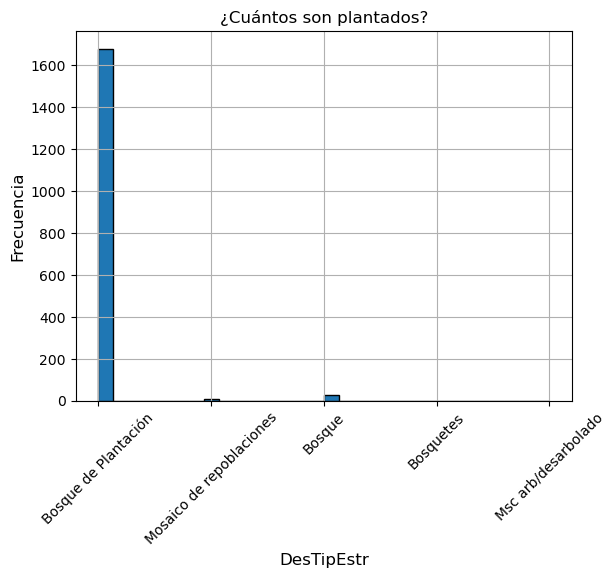

In [53]:
import matplotlib.pyplot as plt

# Crear histograma de la columna que te interesa (por ejemplo, "altura")
euc_polyg["DesTipEstr"].hist(bins=30, edgecolor="black")

# Personalizar el gráfico
plt.title("¿Cuántos son plantados?")
plt.xlabel("DesTipEstr", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.xticks(fontsize=10, rotation=45)

plt.show()

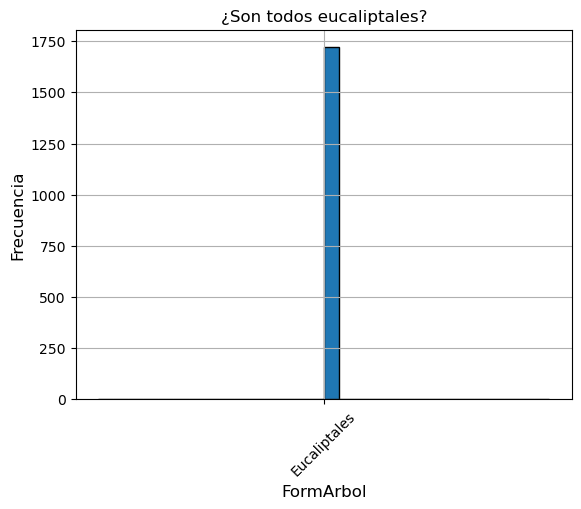

In [54]:
import matplotlib.pyplot as plt

# Crear histograma de la columna que te interesa (por ejemplo, "altura")
euc_polyg["FormArbol"].hist(bins=30, edgecolor="black")

# Personalizar el gráfico
plt.title("¿Son todos eucaliptales?")
plt.xlabel("FormArbol", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.xticks(fontsize=10, rotation=45)

plt.show()

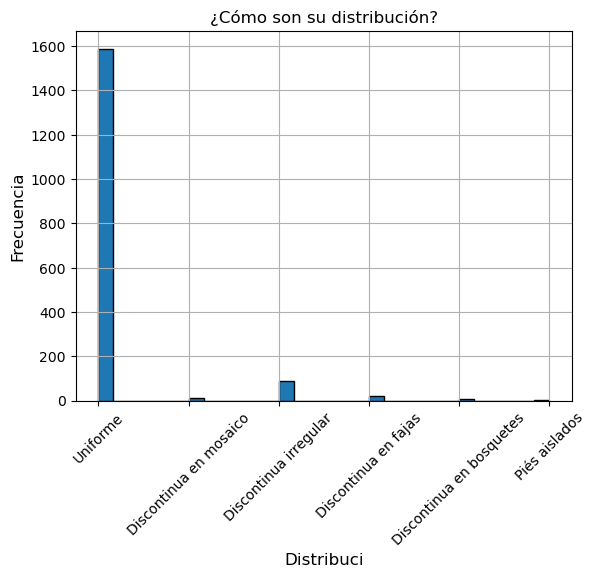

In [56]:
import matplotlib.pyplot as plt

# Crear histograma de la columna que te interesa (por ejemplo, "altura")
euc_polyg["Distribuci"].hist(bins=30, edgecolor="black")

# Personalizar el gráfico
plt.title("¿Cómo son su distribución?")
plt.xlabel("Distribuci", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.xticks(fontsize=10, rotation=45)

plt.show()

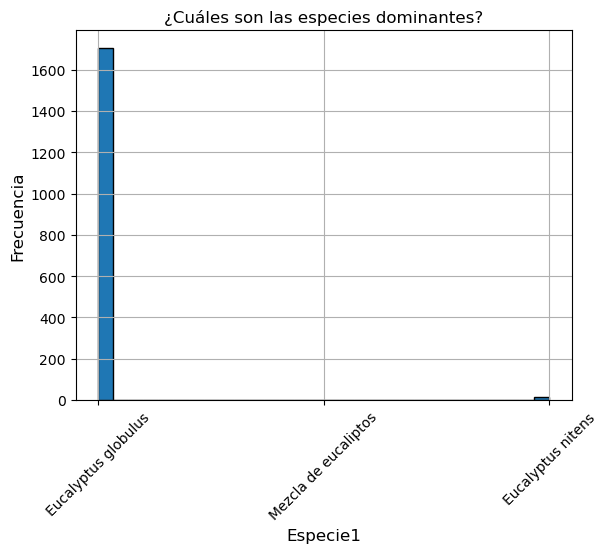

In [58]:
import matplotlib.pyplot as plt

# Crear histograma de la columna que te interesa (por ejemplo, "altura")
euc_polyg["Especie1"].hist(bins=30, edgecolor="black")

# Personalizar el gráfico
plt.title("¿Cuáles son las especies dominantes?")
plt.xlabel("Especie1", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.xticks(fontsize=10, rotation=45)

plt.show()

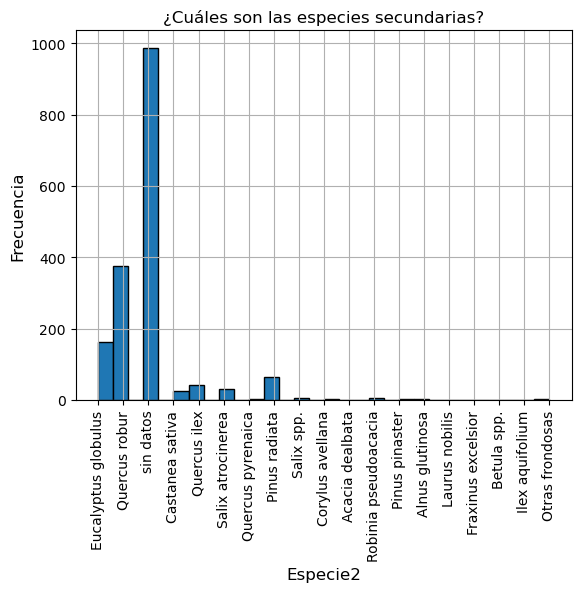

In [60]:
import matplotlib.pyplot as plt

# Crear histograma de la columna que te interesa (por ejemplo, "altura")
euc_polyg["Especie2"].hist(bins=30, edgecolor="black")

# Personalizar el gráfico
plt.title("¿Cuáles son las especies secundarias?")
plt.xlabel("Especie2", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.xticks(fontsize=10, rotation=90)

plt.show()

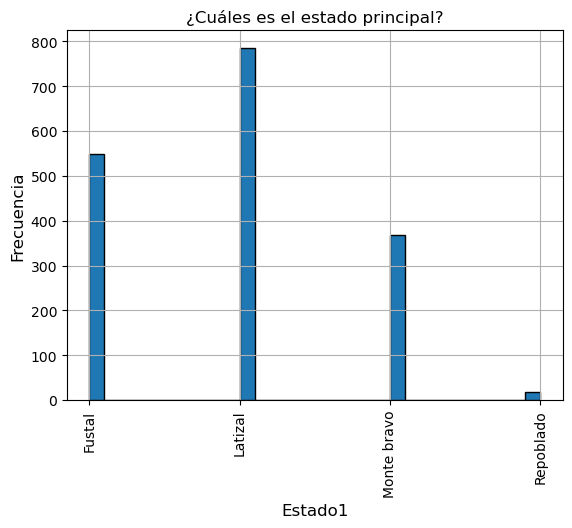

In [62]:
import matplotlib.pyplot as plt

# Crear histograma de la columna que te interesa (por ejemplo, "altura")
euc_polyg["Estado1"].hist(bins=30, edgecolor="black")

# Personalizar el gráfico
plt.title("¿Cuáles es el estado principal?")
plt.xlabel("Estado1", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.xticks(fontsize=10, rotation=90)

plt.show()

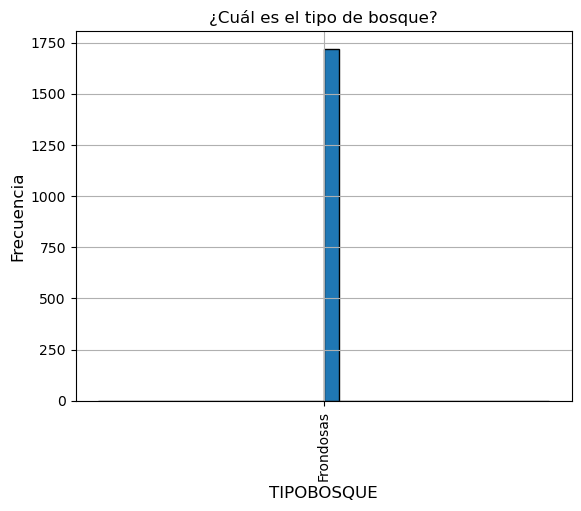

In [63]:
import matplotlib.pyplot as plt

# Crear histograma de la columna que te interesa (por ejemplo, "altura")
euc_polyg["TIPOBOSQUE"].hist(bins=30, edgecolor="black")

# Personalizar el gráfico
plt.title("¿Cuál es el tipo de bosque?")
plt.xlabel("TIPOBOSQUE", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.xticks(fontsize=10, rotation=90)

plt.show()

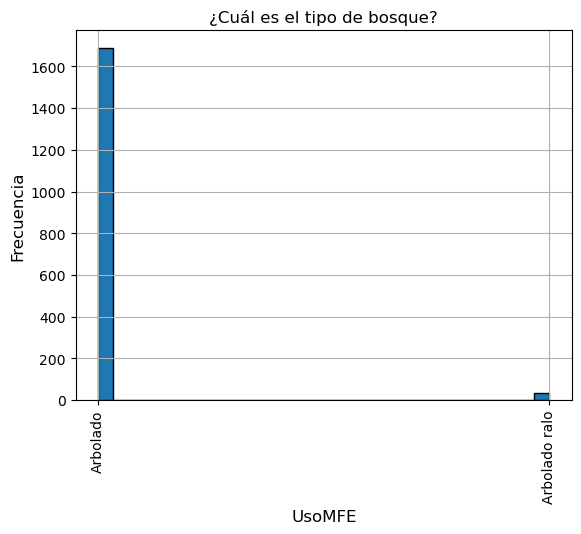

In [64]:
import matplotlib.pyplot as plt

# Crear histograma de la columna que te interesa (por ejemplo, "altura")
euc_polyg["UsoMFE"].hist(bins=30, edgecolor="black")

# Personalizar el gráfico
plt.title("¿Cuál es el tipo de bosque?")
plt.xlabel("UsoMFE", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.xticks(fontsize=10, rotation=90)

plt.show()

Con esta exploración de datos, llego a la conclusión de borrar también las columnas siguientes: "UsoMFE", "TIPOBOSQUE", "FormArbol", "Especie1", "n_REGBIO", "RegBio"

In [65]:
euc_polyg = euc_mfe_cant.drop(columns=["Poligon", "ESTRATOIFN", "ORIGEN", "PRO_F", "ccaa_F", 
                                       "NUT2_NOM", "NUT3_NOM", "FCCARB", "FORARB","path", "layer",
                                      "Shape_Area", "ModeloComb", "Superficie", "n_sp1", "n_estado1",
                                      "TipesTR25", "O1", "n_sp2", "n_estado2", "n_MODCOM", "O2", "Estado2", 
                                       "Especie3", "n_sp3", "FCCTOT", "n_CLAIFN", "O3", "n_estado3", "n_ATRIBUTO",
                                      "Estado3", "FCCMAT", "n_FORmat", "n_distribu", "HMMAT", "FCCHER", "atributo",
                                      "n_FORHER", "FormHerbac", "n_CLAMFE", "LULUCF", "UsoMFE", "TIPOBOSQUE", 
                                       "FormArbol", "Especie1", "n_REGBIO", "RegBio" ])
euc_polyg

,DesTipEstr,Distribuci,Estado1,Especie2,FormArbust,UsoIFN,geometry
2392,Bosque de Plantación,Uniforme,Fustal,Eucalyptus globulus,"Tojares mixtos (incluyendo tojo-brezales, tojo...",Monte arbolado. Bosque de plantaciones,"POLYGON ((376808.859 4795531.215, 376808.167 4..."
2393,Bosque de Plantación,Uniforme,Latizal,Quercus robur,"Orlas, espinares mesófilos mixtos y afines (do...",Monte arbolado. Bosque de plantaciones,"POLYGON ((376792.163 4796557.079, 376786.877 4..."
2394,Bosque de Plantación,Uniforme,Fustal,sin datos,"Orlas, espinares mesófilos mixtos y afines (do...",Monte arbolado. Bosque de plantaciones,"POLYGON ((376118.302 4802814.211, 376079.183 4..."
2395,Bosque de Plantación,Uniforme,Fustal,Castanea sativa,"Orlas, espinares mesófilos mixtos y afines (do...",Monte arbolado. Bosque de plantaciones,"POLYGON ((377397.421 4800004.568, 377399.782 4..."
2396,Bosque de Plantación,Uniforme,Fustal,Castanea sativa,"Orlas, espinares mesófilos mixtos y afines (do...",Monte arbolado. Bosque de plantaciones,"POLYGON ((376108.881 4800574.938, 376109.561 4..."
...,...,...,...,...,...,...,...
4107,Bosque de Plantación,Uniforme,Monte bravo,sin datos,"Tojares mixtos (incluyendo tojo-brezales, tojo...",Monte con arbolado ralo. Bosque de plantaciones,"POLYGON ((406728.418 4797344.683, 406708.351 4..."
4108,Bosque de Plantación,Uniforme,Fustal,Quercus robur,"Orlas, espinares mesófilos mixtos y afines (do...",Monte arbolado. Bosque de plantaciones,"POLYGON ((405132.056 4804865.337, 405139.652 4..."
4109,Bosque de Plantación,Uniforme,Monte bravo,sin datos,"Orlas, espinares mesófilos mixtos y afines (do...",Monte arbolado. Bosque de plantaciones,"POLYGON ((406591.581 4803871.661, 406638.617 4..."
4110,Bosque de Plantación,Uniforme,Fustal,Quercus robur,"Orlas, espinares mesófilos mixtos y afines (do...",Monte arbolado. Bosque de plantaciones,"POLYGON ((406190.541 4805399.105, 406180.187 4..."


Finalmente, vamos a guardar los resultados de la limpieza de datos en la carpeta de resultados, ya que estos son los datos con los que vamos a trabajar. Se asume que estos geodatos son de eucaliptos o eucaliptales (diferencia de si es punto o polígono) en cantabria, por tanto un clima atlántico:

In [75]:
euc_polyg = euc_polyg.to_file(sys.argv[1]+"resultados\\euc_polyg.shp", driver="ESRI Shapefile", encoding="utf-8", engine="fiona")

euc_points = eucal_cant.to_file(sys.argv[1]+"resultados\\euc_points.shp", driver="ESRI Shapefile", encoding="utf-8", engine="fiona")



Ahora vamos a realizar una correlación entre variables cualitativas, hemos escogido la segunda especie más abundante "Especie2" y la formación arbustiva "FormArbust", del mapa forestal. Para ello hemos realizado la correlación Chi-cuadrado de Cramer:

In [79]:

import pandas as pd
import numpy as np
import scipy.stats as stats

# Función para calcular Cramér's V
def cramers_v(x, y):
    """Calcula la correlación entre dos variables categóricas."""
   tabla = pd.crosstab(x, y)  # Crea una tabla de frecuencia
    chi2 = stats.chi2_contingency(tabla_contingencia)[0]  # Calcula Chi-cuadrado
    n = tabla_contingencia.sum().sum()  # Total de observaciones
    phi2 = chi2 / n
    r, k = tabla.shape
    return np.sqrt(phi2 / min(r - 1, k - 1))

# Calcular la correlación entre 'Especie2' y 'FormArbust'
cramers_v_value = cramers_v(euc_polyg["Especie2"], euc_polyg["FormArbust"])
print(f"Correlación de Cramer entre Especie2 y FormArbust: {cramers_v_value:.4f}")


Correlación Cramér’s V entre Especie2 y FormArbust: 0.1107


El resultado es una correlación moderada. (baja de 0 a 0.1, media de 0.1 a 0.3 y alta si es más de 0.3)

In [80]:
print(pd.crosstab(euc_polyg["Especie2"], euc_polyg["FormArbust"]))

FormArbust            Argomales (tojares) atlánticos o subatlánticos (Ulex xpp.)  \
Especie2                                                                           
Acacia dealbata                                                       0            
Alnus glutinosa                                                       0            
Betula spp.                                                           0            
Castanea sativa                                                       4            
Corylus avellana                                                      0            
Eucalyptus globulus                                                  16            
Fraxinus excelsior                                                    0            
Ilex aquifolium                                                       0            
Laurus nobilis                                                        0            
Otras frondosas                                                       0     